In [1]:
# Import libraries
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [16]:
# Visualisation utilities

class PlotTraining(tf.keras.callbacks.Callback):
    def __init__(self,steps_per_epoch, sample_rate=1, zoom=1):
        self.sample_rate = sample_rate
        self.step = 0
        self.zoom = zoom
        self.steps_per_epoch = steps_per_epoch

    def on_train_begin(self, logs={}):
        self.batch_history = {}
        self.batch_step = []
        self.epoch_history = {}
        self.epoch_step = []
        self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
        plt.ioff()

    def on_batch_end(self, batch, logs={}):
        if (batch % self.sample_rate) == 0:
            self.batch_step.append(self.step)
            for k,v in logs.items():
                # do not log "batch" and "size" metrics that do not change
                # do not log training accuracy "acc"
                if k=='batch' or k=='size':# or k=='acc':
                    continue
                self.batch_history.setdefault(k, []).append(v)
        self.step += 1

    def on_epoch_end(self, epoch, logs={}):
        plt.close(self.fig)
        self.axes[0].cla()
        self.axes[1].cla()

        self.axes[0].set_ylim(0, 1.2/self.zoom)
#         self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
        self.axes[1].set_ylim(0, 1+0.1/self.zoom/2)

        self.epoch_step.append(self.step)
        for k,v in logs.items():
            # only log validation metrics
            if not k.startswith('val_'):
                continue
            self.epoch_history.setdefault(k, []).append(v)

        display.clear_output(wait=True)

        for k,v in self.batch_history.items():
            self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k)

        for k,v in self.epoch_history.items():
            self.axes[0 if k.endswith('loss') else 1].plot(np.array(self.epoch_step) / self.steps_per_epoch, v, label=k, linewidth=3)

        self.axes[0].legend()
        self.axes[1].legend()
        self.axes[0].set_xlabel('epochs')
        self.axes[1].set_xlabel('epochs')
        self.axes[0].minorticks_on()
        self.axes[0].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
        self.axes[0].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        self.axes[1].minorticks_on()
        self.axes[1].grid(True, which='major', axis='both', linestyle='-', linewidth=1)
        self.axes[1].grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
        display.display(self.fig)

In [3]:
# Import dataset 
header = ["id", "diagnosis", "radius_m", "texture_m", "perimeter_m", "area_m", "smoothness_m", "compact_m", "concavity_m", "concave_m", "symmetry_m", "fractal_m", "radius_std", "texture_std", "perimeter_std", "area_std", "smoothness_std", "compact_std", "concavity_std", "concave_std", "symmetry_std", "fractal_std", "radius_l", "texture_l", "perimeter_l", "area_l", "smoothness_l", "compact_l", "concavity_l", "concave_l", "symmetry_l", "fractal_l"]
df = pd.read_csv("../data/wdbc.data",header=None,
                names=header)
# df.describe()
# df.dtypes

# To view the data
df.head()

In [6]:
# breastCancer_batches = tf.data.experimental.make_csv_dataset("./data/wdbc.data", batch_size=BATCH_SIZE, num_epochs=EPOCHS,
#                                                             column_names=header,
#                                                             label_name="diagnosis")
# for feature_batch, label_batch in breastCancer_batches.take(1):
#     print("Diagnosis: {}".format(label_batch))
#     print("Features:")
    
#     for key, value in feature_batch.items():
#         print("  {!r:20s}: {}".format(key, value))
    

In [27]:
##################
# Preprocessing  #
##################
df_copy = df.copy()
labels = df_copy.pop('diagnosis')
labels[labels=='M']=1
labels[labels=='B']=0

df_slices = tf.data.Dataset.from_tensor_slices((dict(df_copy), labels))
df_batches = df_slices.batch(BATCH_SIZE)
# print(df_batches)

In [8]:
example_batch = next(iter(df_batches))[0]
example_batch['texture_m']

<tf.Tensor: shape=(5,), dtype=float64, numpy=array([10.38, 17.77, 21.25, 20.38, 14.34])>

In [9]:
##################
# Preprocessing  #
##################
# cat_col = tf.feature_column.categorical_column_with_vocabulary_list(key='diagnosis',
#                                                                    vocabulary_list=['M','B'])
# cat_cols = [tf.feature_column.indicator_column(cat_col)]

feature_columns = []
for h in header:
    if not h == 'id' and not h=='diagnosis':
        feature_columns.append(tf.feature_column.numeric_column(h))

# Define a feature layer
featureLayer = tf.keras.layers.DenseFeatures(feature_columns)


In [26]:
#####################
# Hyper-parameters  #
#####################
BATCH_SIZE = 5
EPOCHS = 10
VALID_SPLIT = 0.3
STEPS_PER_EPOCH = (df.shape[0]*(1-VALID_SPLIT))//BATCH_SIZE


In [11]:
#######################
# Create a model      #
#######################
seqModel = tf.keras.Sequential(
[#featureLayer,
 tf.keras.layers.Input(shape=(30,)),
 tf.keras.layers.Dense(100),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(60),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(50),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(10),
 tf.keras.layers.Activation('relu'),
 
 tf.keras.layers.Dense(1, activation='softmax')
]
)

########################
# Summarize the model  #
########################
seqModel.summary()
tf.keras.utils.plot_model(seqModel,'model.png', show_shapes=True)


########################
# Compile the model    #
########################
seqModel.compile(optimizer=tf.keras.optimizers.SGD(lr=0.3), 
                 loss=tf.keras.losses.BinaryCrossentropy(), 
                 metrics=['accuracy'])

#######################
# Fit the model       #
#######################
# seqModel.fit(x=df_batches, epochs=EPOCHS)

# X = df.iloc[:, 2:]
# X = X.to_numpy()
# Y = labels.to_numpy()
# seqModel.fit(x=X.astype(np.float32), y=Y.astype(np.float32), epochs=EPOCHS, validation_split=0.3

X = tf.convert_to_tensor(df.iloc[:, 2:].to_numpy())
Y = tf.convert_to_tensor(labels)

# Utility callback that displays training curves
plot_training = PlotTraining(STEPS_PER_EPOCH, sample_rate=1, zoom=1)

seqModel.fit(x=X, y=Y, epochs=EPOCHS, batch_size= BATCH_SIZE, validation_split=VALID_SPLIT, callbacks=[plot_training])

Train on 398 samples, validate on 171 samples
Epoch 1/10
398/398 [==============================] - 0s 113us/sample - loss: 8.6208 - accuracy: 0.4347 - val_loss: 11.7713 - val_accuracy: 0.2281
Epoch 2/10
398/398 [==============================] - 0s 117us/sample - loss: 8.6208 - accuracy: 0.4347 - val_loss: 11.7713 - val_accuracy: 0.2281
Epoch 3/10
398/398 [==============================] - 0s 114us/sample - loss: 8.6208 - accuracy: 0.4347 - val_loss: 11.7713 - val_accuracy: 0.2281
Epoch 4/10
398/398 [==============================] - 0s 112us/sample - loss: 8.6208 - accuracy: 0.4347 - val_loss: 11.7713 - val_accuracy: 0.2281
Epoch 5/10
398/398 [==============================] - 0s 113us/sample - loss: 8.6208 - accuracy: 0.4347 - val_loss: 11.7713 - val_accuracy: 0.2281
Epoch 6/10
398/398 [==============================] - 0s 114us/sample - loss: 8.6208 - accuracy: 0.4347 - val_loss: 11.7713 - val_accuracy: 0.2281
Epoch 7/10
398/398 [==============================] - 0s 129us/sample - 

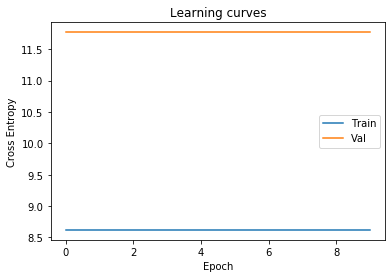

In [15]:
history = seqModel.fit(x=X, y=Y, epochs=EPOCHS, validation_split=0.3)

# Plot the learning curves 
plt.title('Learning curves')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy')
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Val')
plt.legend()
plt.show()